In [79]:
import pandas as pd
import numpy as np

In [82]:
train = pd.read_csv('/content/tamil_offensive_full_train.tsv', error_bad_lines=False, sep="\t", header=None)
test= pd.read_csv('/content/tamil_offensive_full_dev.tsv', error_bad_lines=False, sep="\t", header=None)
print(train)
print(test)

                                                       0              1
0                      movie vara level la Erika poguthu  Not_offensive
1      I love Ajith Kumar Vivegam movie inki mjy bht ...      not-Tamil
2              Padam nalla comedy padama irukum polaye..  Not_offensive
3      karthick subburaj anne .... intha padam vetri ...  Not_offensive
4      கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁  Not_offensive
...                                                  ...            ...
35134  Trending number #2 idhukku nammalam karanamnu ...  Not_offensive
35135  Movie script super, athuvum HIP HOP Tamizha mu...  Not_offensive
35136                       Just 3k likes for 300k likes  Not_offensive
35137                          Aaloo le lo. Kanda le lo.      not-Tamil
35138  நாமக்கல் மாவட்டம்  வன்னியர் சார்பாக திரௌபதி பட...  Not_offensive

[35139 rows x 2 columns]
                                                      0                                1
0                    

In [83]:
df=train.filter([1,0], axis=1)
df_test=test.filter([1,0],axis=1)

In [84]:
df[1].value_counts()

Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: 1, dtype: int64

In [85]:
#removing @ and #
def punc(df):
    df[0] = df[0].str.replace('[#@()]','')
    df[0]=df[0].str.replace('[^\w\s]','')
    print(df)

In [86]:
punc(df)
punc(df_test)

                   1                                                  0
0      Not_offensive                  movie vara level la Erika poguthu
1          not-Tamil  I love Ajith Kumar Vivegam movie inki mjy bht ...
2      Not_offensive            Padam nalla comedy padama irukum polaye
3      Not_offensive  karthick subburaj anne  intha padam vetri aday...
4      Not_offensive                      கவணடர தவரசரபக வறற பற வழததககள 
...              ...                                                ...
35134  Not_offensive  Trending number 2 idhukku nammalam karanamnu s...
35135  Not_offensive  Movie script super athuvum HIP HOP Tamizha mus...
35136  Not_offensive                       Just 3k likes for 300k likes
35137      not-Tamil                            Aaloo le lo Kanda le lo
35138  Not_offensive  நமககல மவடடம  வனனயர சரபக தரபத படம  மபரம வறற பற ...

[35139 rows x 2 columns]
                                    1                                                  0
0                    

In [87]:
import fastai
from fastai import *
from fastai.text import * 
from functools import partial
import io
import os

In [88]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df, valid_df = df_test, path = "")

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [89]:
data_lm.show_batch

<bound method DataBunch.show_batch of TextLMDataBunch;

Train: LabelList (35139 items)
x: LMTextList
xxbos movie vara level la xxmaj erika poguthu,xxbos i love xxmaj ajith xxmaj kumar xxmaj vivegam movie inki xxunk bht achi lgi,xxbos xxmaj padam nalla comedy padama irukum polaye,xxbos karthick subburaj anne intha padam vetri adaya xxunk ennudaya valthukkal,xxbos கவணடர xxunk வறற பற வழததககள
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (4388 items)
x: LMTextList
xxbos xxmaj handsome hunk xxunk vaa thalaivaa,xxbos தனகச மவடடம நடர சமதயம சரபக வழததககள,xxbos je xxunk xxunk bravo xxunk clip de xxunk xxunk j xxunk xxunk xxunk,xxbos சறபப மலம இத பனற படபபகள மக அவசயம,xxbos xxmaj vera level xxup bgm semma trailer
y: LMLabelList
,,,,
Path: .;

Test: None>

In [90]:
#loading AWD_LSTM language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.97E-02
Min loss divided by 10: 5.22E-03


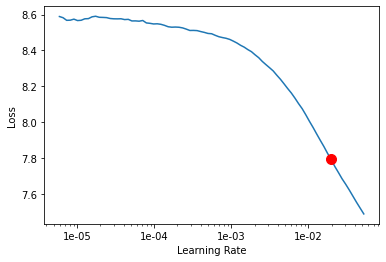

In [91]:
learn.lr_find(start_lr=2e-6, end_lr=1e-1)
learn.recorder.plot(suggestion = True)

In [92]:
#fitting the data
learn.fit_one_cycle(2, 5e-2)
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,5.979931,5.198833,0.269780,00:23
1,5.118211,4.965881,0.282160,00:23


In [93]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.706778,4.842215,0.284701,00:30
1,4.451332,4.732826,0.294248,00:30
2,3.695271,4.859400,0.293115,00:30


In [94]:
learn.freeze_to(-1)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-04
Min loss divided by 10: 2.29E-05


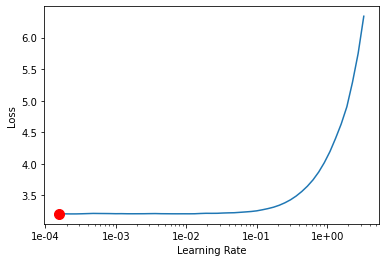

In [95]:
learn.recorder.plot(skip_start=40, suggestion=True)

In [96]:
learn.fit_one_cycle(3, slice(2e-2/(2.6**4), 2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.510229,5.000235,0.287431,00:24
1,3.363650,5.028054,0.285869,00:24
2,2.882377,5.057755,0.285817,00:24


In [97]:
learn.freeze_to(-2)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-03
Min loss divided by 10: 1.10E-03


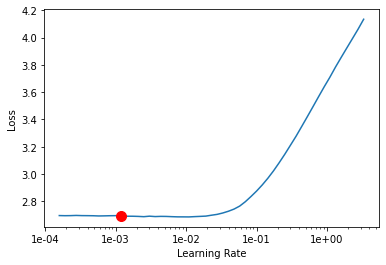

In [98]:
learn.recorder.plot(skip_start=40, suggestion=True)

In [99]:
learn.fit_one_cycle(3, slice(6e-3/(2.6**4), 6e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.755655,5.226364,0.279310,00:25
1,2.662618,5.276317,0.279653,00:25
2,2.426979,5.344045,0.277146,00:25


In [100]:
#save the encoder model
learn.save_encoder('my_encoder')

In [101]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df, valid_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [102]:
#building classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=1)])

#loading the saved encoder
learn.load_encoder('my_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (35139 items)
x: TextList
xxbos movie vara level la xxmaj erika poguthu,xxbos i love xxmaj ajith xxmaj kumar xxmaj vivegam movie inki xxunk bht achi lgi,xxbos xxmaj padam nalla comedy padama irukum polaye,xxbos karthick subburaj anne intha padam vetri adaya xxunk ennudaya valthukkal,xxbos கவணடர xxunk வறற பற வழததககள
y: CategoryList
Not_offensive,not-Tamil,Not_offensive,Not_offensive,Not_offensive
Path: .;

Valid: LabelList (4388 items)
x: TextList
xxbos xxmaj handsome hunk xxunk vaa thalaivaa,xxbos தனகச மவடடம நடர சமதயம சரபக வழததககள,xxbos je xxunk xxunk bravo xxunk clip de xxunk xxunk j xxunk xxunk xxunk,xxbos சறபப மலம இத பனற படபபகள மக அவசயம,xxbos xxmaj vera level xxup bgm semma trailer
y: CategoryList
Not_offensive,Not_offensive,not-Tamil,Not_offensive,Not_offensive
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(19328, 400, padding_idx=1)
      (encoder_dp): Embe

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 3.63E-02


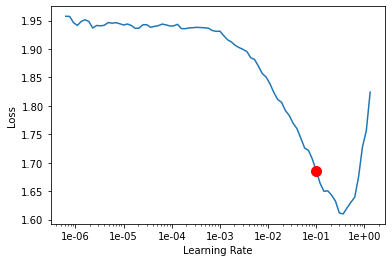

In [103]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [104]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.813229,0.758771,0.754330,0.351108,00:17
1,0.756023,0.725982,0.758432,0.000000,00:17
2,0.742122,0.712648,0.759799,0.000000,00:17


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

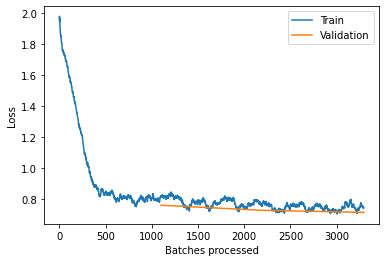

In [105]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.02E-06


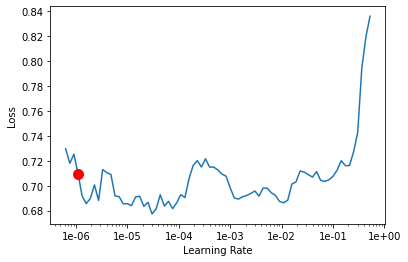

In [106]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [107]:
learn.freeze_to(-2) # unfreeze last 2 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.696915,0.707270,0.764357,0.355490,00:19
1,0.704371,0.684617,0.768459,0.000000,00:20


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 4.79E-05


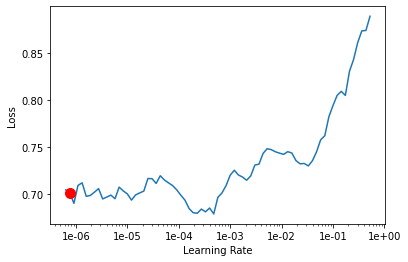

In [108]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [109]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5.3e-3/(2.6**4),5.31e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.714638,0.684729,0.767320,0.394278,00:32
1,0.608671,0.658268,0.774385,0.000000,00:32


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

In [110]:
learn.freeze_to(-4) # unfreeze last 4 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.freeze_to(-5) # unfreeze last 5 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

# Unfreezing all the layers and training
learn.unfreeze() # unfreze all
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.609898,0.676061,0.773701,0.407564,00:44
1,0.497316,0.697466,0.770055,0.000000,00:40


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.521011,0.696235,0.771650,0.450504,00:47
1,0.394628,0.748558,0.763218,0.450620,00:46


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.350253,0.797470,0.764585,0.446045,00:48
1,0.298632,0.829529,0.765725,0.453571,00:45
2,0.289223,0.839073,0.765953,0.453983,00:47


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/usr/local/lib/python3.6/dist-packages/nu

In [111]:
#getting the predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)

In [112]:
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5
row_0,,,,,,
0,2918,158,129,35,149,35
1,80,81,34,8,30,2
2,81,18,93,8,32,3
3,2,0,0,0,2,0
4,87,37,48,14,140,3
5,25,1,3,0,3,129


In [113]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
cm=confusion_matrix(predictions,targets)
print(cm)
score = accuracy_score( predictions, targets)
print(score)

[[2918  158  129   35  149   35]
 [  80   81   34    8   30    2]
 [  81   18   93    8   32    3]
 [   2    0    0    0    2    0]
 [  87   37   48   14  140    3]
 [  25    1    3    0    3  129]]
0.7659525979945305


In [114]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,targets, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      3424
           1       0.27      0.34      0.31       235
           2       0.30      0.40      0.34       235
           3       0.00      0.00      0.00         4
           4       0.39      0.43      0.41       329
           5       0.75      0.80      0.77       161

    accuracy                           0.77      4388
   macro avg       0.44      0.47      0.45      4388
weighted avg       0.80      0.77      0.78      4388

